# MLClass. "Прикладной анализ данных"
# Модуль "Машинное обучение с помощью Python"
<img src="../img/mlclass_logo.jpg" height="240" width="240">
## Автор материала: преподаватель ФКН НИУ ВШЭ Кашницкий Юрий
Материал распространяется на условиях лицензии <a href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-Share Alike 4.0</a>. Можно использовать в любых целях, но с обязательным упоминанием автора курса и аффилиации.

# Урок 4. Обучение с учителем. Ансамбли классификаторов
## Часть 6. Регуляризация

В этом разделе мы на примерах покажем, что такое переобучение и метод борьбы с ним - регуляризация.
В самом общем виде регуляризация - это штраф модели за ее сложность. 

Рассмотрим пример, в котором через 11 точек (синие), лежаших вблизи синусоиды (зеленая), будем проводить полиномы разных степеней.
С линейной регрессией мы познакомимся в главе 3, пока же хватит представления, что красные кривые строятся так, чтобы минимизировать
сумму расстояний от синих точек до кривой. 

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


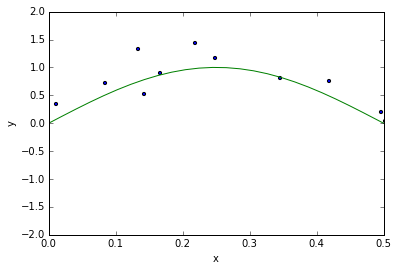

In [1]:
%pylab inline
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# 11 точек
n_samples = 11

# одна из синусоид
def my_sin(x):
    return np.sin(2 * np.pi * x)

# для воспроизводимости генерации случайных точек
np.random.seed(9)

# генерируем координаты случайных точек возле синусоиды
x = np.random.uniform(0, 1, size=n_samples)[:, np.newaxis]
y = my_sin(x) + np.random.normal(scale=0.3, size=n_samples)[:, np.newaxis]

def plot_points_and_sin(x, y, f):
    ax = plt.gca()
    # точки для отображения
    x_plot = np.linspace(0, 1)
    ax.plot(x_plot, f(x_plot), color='green')
    ax.scatter(x, y, s=10)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 0.5))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    
plot_points_and_sin(x, y, f=my_sin)

Отобразим кривые 3, 5, 7 и 9 степеней, проходящие через эти точки и минимизирующие сумму квадратов расстояний до точек. 

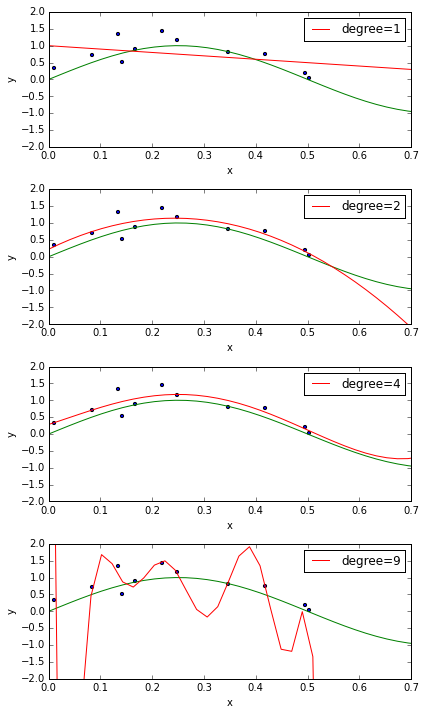

In [2]:
fig, ax_rows = plt.subplots(4, 1, figsize=(6, 10))

# функция для отображения синусоиды и регрессионной кривой
def plot_approximation(est, ax, x, y, x_plot, f, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(x_plot, f(x_plot), color='green')
    ax.scatter(x, y, s=10)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 0.7))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right')  #, fontsize='small')

# отображаем 4 раза
degrees = [1, 2, 4, 9]
for degree, ax_row in zip(degrees, ax_rows):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(x, y)
    plot_approximation(est, ax_row, x, y, x_plot=np.linspace(0, 1), f=my_sin, label='degree=%r' % degree)

plt.tight_layout()

В этом примере степень полинома регрессионной кривой - по сути, сложность модели. 
В случае кривой первой степени (прямой) модель слишком простая, и она плохо обощается на точки синусоиды справа.
То есть она плохо предскажет координату `y` для точек с координатой `x` из [0.5,0.7]. 
2-я степень полинома - уже ближе, но видим, что 4-я степень лучше всего подходит для приближения синусоиды на выбранном интервале.
Кривая 9-ой степени проходит почти точно через большинство синих точек, но очень далеко от права края синусоиды. 
В этом случае модель слишком сложная, переобученная.

В этом примере одна из возможных мер регуляризации - ограничение степени полинома регрессионной кривой.

**Суть регуляризации**

Log-loss без регуляризации: $$L(X, y) = \sum_{i=1}^N y^{(i)}ln(\sigma(\theta^TX_i)) + (1 - y^{(i)})ln(1 - \sigma(\theta^TX_i))$$
Log-loss с регуляризацией: $$L(X, y) = \sum_{i=1}^N y^{(i)}ln(\sigma(\theta^TX_i)) + (1 - y^{(i)})ln(1 - \sigma(\theta^TX_i)) + \frac{\lambda}{2M} \sum_{j=1}^M \theta_j^2,$$
где N - число объектов, M - число признаков.

Регуляризация может не позволить параметрам модели $\theta$ достигать больших значений.

# Пример

Посмотрим, как регуляризация влияет на качество классификации, на наборе данных по тестированию микрочипов из курса Andrew Ng по машинному обучению. 
Будем использовать машину опорных векторов (SVM) с гауссовым ядром и варьировать параметр регуляризации C.
Сначала посмотрим, как регуляризация влияет на разделяющую границу классификатора, интуитивно распознаем переобучение и недообучение.
Потом численно установим ,близкий к оптимальному параметр регуляризации с помощью скользящего контроля (`cross-validation`) и сеточного перебора (`GridSearch`). 

In [3]:
import pandas as pd
from matplotlib.cm import gray
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

Загружаем данные с помощью метода read_csv из библиотеки pandas. В этом наборе данных для 118 микрочипов (объекты) указаны результаты двух тестов по контролю качества (два числовых признака) и сказано, пустили ли микрочип в производство. Признаки уже стандартизованы, то есть из всех значений вычтены средние по столбцам. Таким образом, "среднему" микрочипу соответсвуют нулевые значения результатов тестов.  

In [4]:
# загрузка данных
data = pd.read_csv('../data/microchip_tests.txt',
                   header=None, names = ('test1','test2','released'))
# информация о наборе данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 117
Data columns (total 3 columns):
test1       118 non-null float64
test2       118 non-null float64
released    118 non-null int64
dtypes: float64(2), int64(1)
memory usage: 3.7 KB


Посмотрим на первые и последние 5 строк.

In [5]:
data.head(5)

,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [6]:
data.tail(5)

,test1,test2,released
113,-0.720620,0.538740,0
114,-0.593890,0.494880,0
115,-0.484450,0.999270,0
116,-0.006336,0.999270,0
117,0.632650,-0.030612,0


Сохраним обучающую выборку и метки целевого класса в отдельных массивах NumPy.

In [7]:
X = data.ix[:,0:2].values
y = data.ix[:,2].values

Отображаем данные. Белый цвет соответствует нормальным чипам, черный - бракованным.  

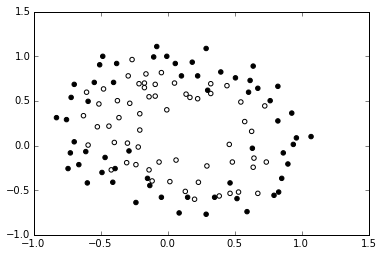

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=gray)

Определяем функцию для отображения разделяющей кривой классификатора

In [9]:
def plot_boundary(X, y, grid_step=.01):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))


    # каждой точке в сетке [x_min, m_max]x[y_min, y_max]
    # ставим в ссответствие свой цвет
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

Обучаем классификатор SVM с гауссовым ядром и параметром регуляризации С = $10^7$. (Это может занять некоторое время). Чем меньше C, тем выше регуляризация.
Также проверим точность классификатора на обучающей выборке.

('\xd0\xa2\xd0\xbe\xd1\x87\xd0\xbd\xd0\xbe\xd1\x81\xd1\x82\xd1\x8c \xd0\xba\xd0\xbb\xd0\xb0\xd1\x81\xd1\x81\xd0\xb8\xd1\x84\xd0\xb8\xd0\xba\xd0\xb0\xd1\x82\xd0\xbe\xd1\x80\xd0\xb0 \xd0\xbd\xd0\xb0 \xd0\xbe\xd0\xb1\xd1\x83\xd1\x87\xd0\xb0\xd1\x8e\xd1\x89\xd0\xb5\xd0\xb9 \xd0\xb2\xd1\x8b\xd0\xb1\xd0\xbe\xd1\x80\xd0\xba\xd0\xb5:', 0.881)


//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


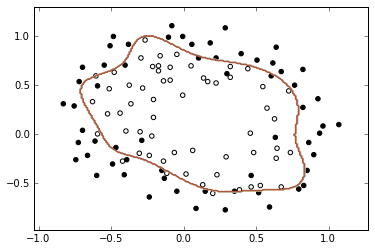

In [10]:
C = 10 ** 7  # Параметр регуляризации в SVM
# классификатор SVM с гауссовым ядром
clf = SVC(kernel = 'rbf', C=C)
# обучаем классификатор
clf.fit(X, y)

plot_boundary(X, y, grid_step=.01)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=gray)

# проверяем точность классификатора на обучающей выборке
print("Точность классификатора на обучающей выборке:", 
      round(clf.score(X, y),3))

Видим, что классификатор сильно подстроился под обучающую выборку - правильно опредеделил метки около 88% обучающих примеров. 
Разделяющая граница сильно изогнута. Но возможно, как раз поэтому для новых чипов такой классификатор будет плохо работать.  

Теперь сделаем то же самое, но для малого параметра С = 0.2 (сильная регуляризация). 

('\xd0\xa2\xd0\xbe\xd1\x87\xd0\xbd\xd0\xbe\xd1\x81\xd1\x82\xd1\x8c \xd0\xba\xd0\xbb\xd0\xb0\xd1\x81\xd1\x81\xd0\xb8\xd1\x84\xd0\xb8\xd0\xba\xd0\xb0\xd1\x82\xd0\xbe\xd1\x80\xd0\xb0 \xd0\xbd\xd0\xb0 \xd0\xbe\xd0\xb1\xd1\x83\xd1\x87\xd0\xb0\xd1\x8e\xd1\x89\xd0\xb5\xd0\xb9 \xd0\xb2\xd1\x8b\xd0\xb1\xd0\xbe\xd1\x80\xd0\xba\xd0\xb5:', 0.585)


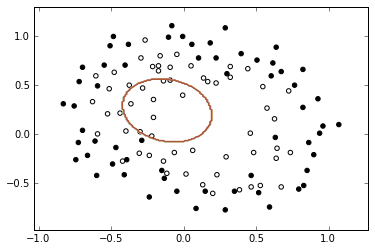

In [11]:
C = 0.2  # Параметр регуляризации в SVM
# классификатор SVM с гауссовым ядром
clf = SVC(kernel = 'rbf', C=C)
# обучаем классификатор
clf.fit(X, y)

plot_boundary(X, y, grid_step=.01)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=gray)

# проверяем точность классификатора на обучающей выборке
print("Точность классификатора на обучающей выборке:", 
      round(clf.score(X, y),3))

На этот раз, наоборот, классифкатор слишком слабо подстроился под обучающую выборку - правильно опредеделил метки всего около 60% обучающих примеров.
Скорее всего, такая модель тоже плохо обобщится на новые данные.

Наконец, используем параметр C=1000.

('\xd0\xa2\xd0\xbe\xd1\x87\xd0\xbd\xd0\xbe\xd1\x81\xd1\x82\xd1\x8c \xd0\xba\xd0\xbb\xd0\xb0\xd1\x81\xd1\x81\xd0\xb8\xd1\x84\xd0\xb8\xd0\xba\xd0\xb0\xd1\x82\xd0\xbe\xd1\x80\xd0\xb0 \xd0\xbd\xd0\xb0 \xd0\xbe\xd0\xb1\xd1\x83\xd1\x87\xd0\xb0\xd1\x8e\xd1\x89\xd0\xb5\xd0\xb9 \xd0\xb2\xd1\x8b\xd0\xb1\xd0\xbe\xd1\x80\xd0\xba\xd0\xb5:', 0.856)


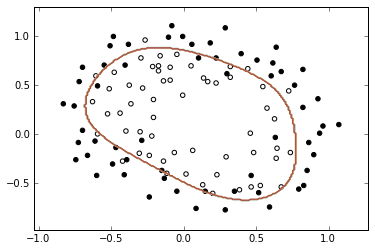

In [12]:
C = 1000 # Параметр регуляризации в SVM
# классификатор SVM с гауссовым ядром
clf = SVC(kernel = 'rbf', C=C)
# обучаем классификатор
clf.fit(X, y)

plot_boundary(X, y, grid_step=.01)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=gray)

# проверяем точность классификатора на обучающей выборке
print("Точность классификатора на обучающей выборке:",
      round(clf.score(X, y),3))

На этот раз, кажется, классификатор построил неплохую плавную границу, при этом он правильно учел метки почти 86% обучающих примеров. 
Скорее всего, классификатор, обученный таким образом, лучше предскажет метки новых примеров. 

### Скользящий контроль
Посмотрим на точность классификации машины опорных векторов с тремя разными параметрами `C`
в процессе 10-кратного скользящего контроля. Напомним, что это значит, что обучающая выборка делится на
10 частей с сохранением пропорцими значений целевого класса. Обучение происходит 10 раз на 9 частях, а точность
классификации проверяется на оставшейся части. 
Сравним средную точность классификации на скользящем контроле для трех параметров `C`.  

In [13]:
scores1 = cross_val_score(SVC(C=10**7), X, y, scoring='accuracy', cv=10)
print(scores1, round(scores1.mean(), 3))
scores2 = cross_val_score(SVC(C=0.2), X, y, scoring='accuracy', cv=10)
print(scores2, round(scores2.mean(), 3))
scores3 = cross_val_score(SVC(C=1000), X, y, scoring='accuracy', cv=10)
print(scores3, round(scores3.mean(), 3))

(array([ 0.83333333,  0.66666667,  0.33333333,  0.41666667,  0.66666667,
        0.58333333,  0.75      ,  0.58333333,  0.45454545,  0.81818182]), 0.611)
(array([ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.25      ,
        0.58333333,  0.16666667,  0.33333333,  0.27272727,  0.63636364]), 0.424)
(array([ 0.83333333,  0.5       ,  0.66666667,  0.41666667,  0.66666667,
        0.66666667,  1.        ,  0.83333333,  0.63636364,  0.81818182]), 0.704)


Как нам и показалось при анализе построенных разделяющих границ, при параметах  `С` = $10^7$ и `C` = 0.2 `SVM` плохо классифицирует те примеры, на которых он не обучался. 
Средняя точность на скользящем контроле в первом случае оказалась равной 61% во втором - всего 42%. При `С` = 1000 модель лучше обобщается на новые примеры (70%).

### Поиск оптимального параметра регуляризации

Поскольку пока, к сожалению, не существует строгой теории оптимизации параметров регуляризации, на практике перебором ищут субоптимальные параметры. 
Конечно, это вычислительно сложно. Также сложность в том, что надо хотя бы примерно знать, где искать, то есть в каком диапазоне значений. 
Как вы увидели, на скользящем контроле выше точность классификации получилась при параметре `C`=1000. 
Будем перебирать значения `C` от $10^3$ до $10^5$ с шагом 1000 и использовать 10-кратный скользящий контроль. Это 990 обучений классификатора.

In [14]:
parameters = {'kernel':['rbf'], 'C':np.arange(10**3, 10**5, 1000)}
grid_search_svm = GridSearchCV(SVC(), 
                               parameters, cv=10, verbose=1, n_jobs=4)
grid_search_svm.fit(X,y)

Fitting 10 folds for each of 99 candidates, totalling 990 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 jobs       | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 450 jobs       | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 800 jobs       | elapsed:   36.0s
[Parallel(n_jobs=4)]: Done 984 out of 990 | elapsed:   56.9s remaining:    0.3s
[Parallel(n_jobs=4)]: Done 990 out of 990 | elapsed:   57.6s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=4,
       param_grid={'kernel': ['rbf'], 'C': array([ 1000,  2000, ..., 98000, 99000])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=1)

Видим, что среди выбранных значений параметра лучшим оказалось `C` = 9000.

In [15]:
print("Лучшие параметры и точность классификации на скользящем контроле: {0}, {1}"
      .format(grid_search_svm.best_params_, 
              round(grid_search_svm.best_score_,3)))

Лучшие параметры и точность классификации на скользящем контроле: {'kernel': 'rbf', 'C': 9000}, 0.712


Для более точного нахождения "хорошего" значения параметра повторим описк в диапазоне [7000, 11000] с шагом 100. 

In [16]:
parameters_finer = {'kernel':['rbf'], 'C':np.arange(7000, 11000, 100)}
grid_search_svm_finer = GridSearchCV(SVC(), 
                                     parameters_finer, 
                                     cv=10, verbose=1, n_jobs=4)
grid_search_svm_finer.fit(X,y)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 200 jobs       | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    5.5s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=4,
       param_grid={'kernel': ['rbf'], 'C': array([ 7000,  7100,  7200,  7300,  7400,  7500,  7600,  7700,  7800,
        7900,  8000,  8100,  8200,  8300,  8400,  8500,  8600,  8700,
        8800,  8900,  9000,  9100,  9200,  9300,  9400,  9500,  9600,
        9700,  9800,  9900, 10000, 10100, 10200, 10300, 10400, 10500,
       10600, 10700, 10800, 10900])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=1)

In [17]:
print("Лучшие параметры и точность классификации на скользящем контроле: {0}, {1}"
      .format(grid_search_svm_finer.best_params_, 
              round(grid_search_svm_finer.best_score_,5)))

Лучшие параметры и точность классификации на скользящем контроле: {'kernel': 'rbf', 'C': 9800}, 0.72034


Наконец, переберем параметры в еще более узком диапазоне [9000,10600] с шагом 20.

In [18]:
parameters_even_finer = {'kernel':['rbf'], 'C':np.arange(9000, 10600, 20)}
grid_search_svm_even_finer = GridSearchCV(SVC(), parameters_even_finer, cv=10, verbose=1, n_jobs=4)
grid_search_svm_even_finer.fit(X,y)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 200 jobs       | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 450 jobs       | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 794 out of 800 | elapsed:   12.9s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:   13.0s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=4,
       param_grid={'kernel': ['rbf'], 'C': array([ 9000,  9020, ..., 10560, 10580])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=1)

In [19]:
print("Лучшие параметры и точность классификации на скользящем контроле: {0}, {1}"
      .format(grid_search_svm_even_finer.best_params_, 
              round(grid_search_svm_even_finer.best_score_,5)))

Лучшие параметры и точность классификации на скользящем контроле: {'kernel': 'rbf', 'C': 9720}, 0.72034


Видим, что последний перебор параметов уже не улучшил точность на скользящем контроле.   